In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scirpy as ir
from matplotlib import pyplot as plt, cm as mpl_cm
from cycler import cycler
from tcr_processing import *
import datetime
import csv
import anndata as an
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scanorama

sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [2]:
    def load_data(contigs,feature_matrix):

        '''Load 10X transcriptomic and cell binding data'''
        
        print('Loading TCR binding and transcriptomics data')
        
                
        if not contigs[-3:]=='csv':
            raise TypeError('Contigs file should be in csv format')

        if not feature_matrix[-2:]=='h5':
            raise TypeError('Contigs file should be in h5 format')
        
        # Load TCR data
        adata_tcr = ir.io.read_10x_vdj(contigs)

        # Load associated transcriptomics data
        adata = sc.read_10x_h5(feature_matrix)

        # Merge
        ir.pp.merge_with_ir(adata, adata_tcr)

        print("Data loaded to Ann Object with shape: ",adata.shape)
        
        return adata

files=[("data/donor%s/vdj_v1_hs_aggregated_donor%s_all_contig_annotations.csv"%(donor,donor),
"data/donor%s/vdj_v1_hs_aggregated_donor%s_filtered_feature_bc_matrix.h5"%(donor,donor)) for donor in range(1,5)]
adata1, adata2, adata3, adata4 = [load_data(pair[0],pair[1]) for pair in files]

Loading TCR binding and transcriptomics data


In [10]:
adata1

AnnData object with n_obs × n_vars = 55206 × 33538
    obs: 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir'
    var: 'gene_ids

In [199]:
def prepare_metrics(adata):
    adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)
    return adata

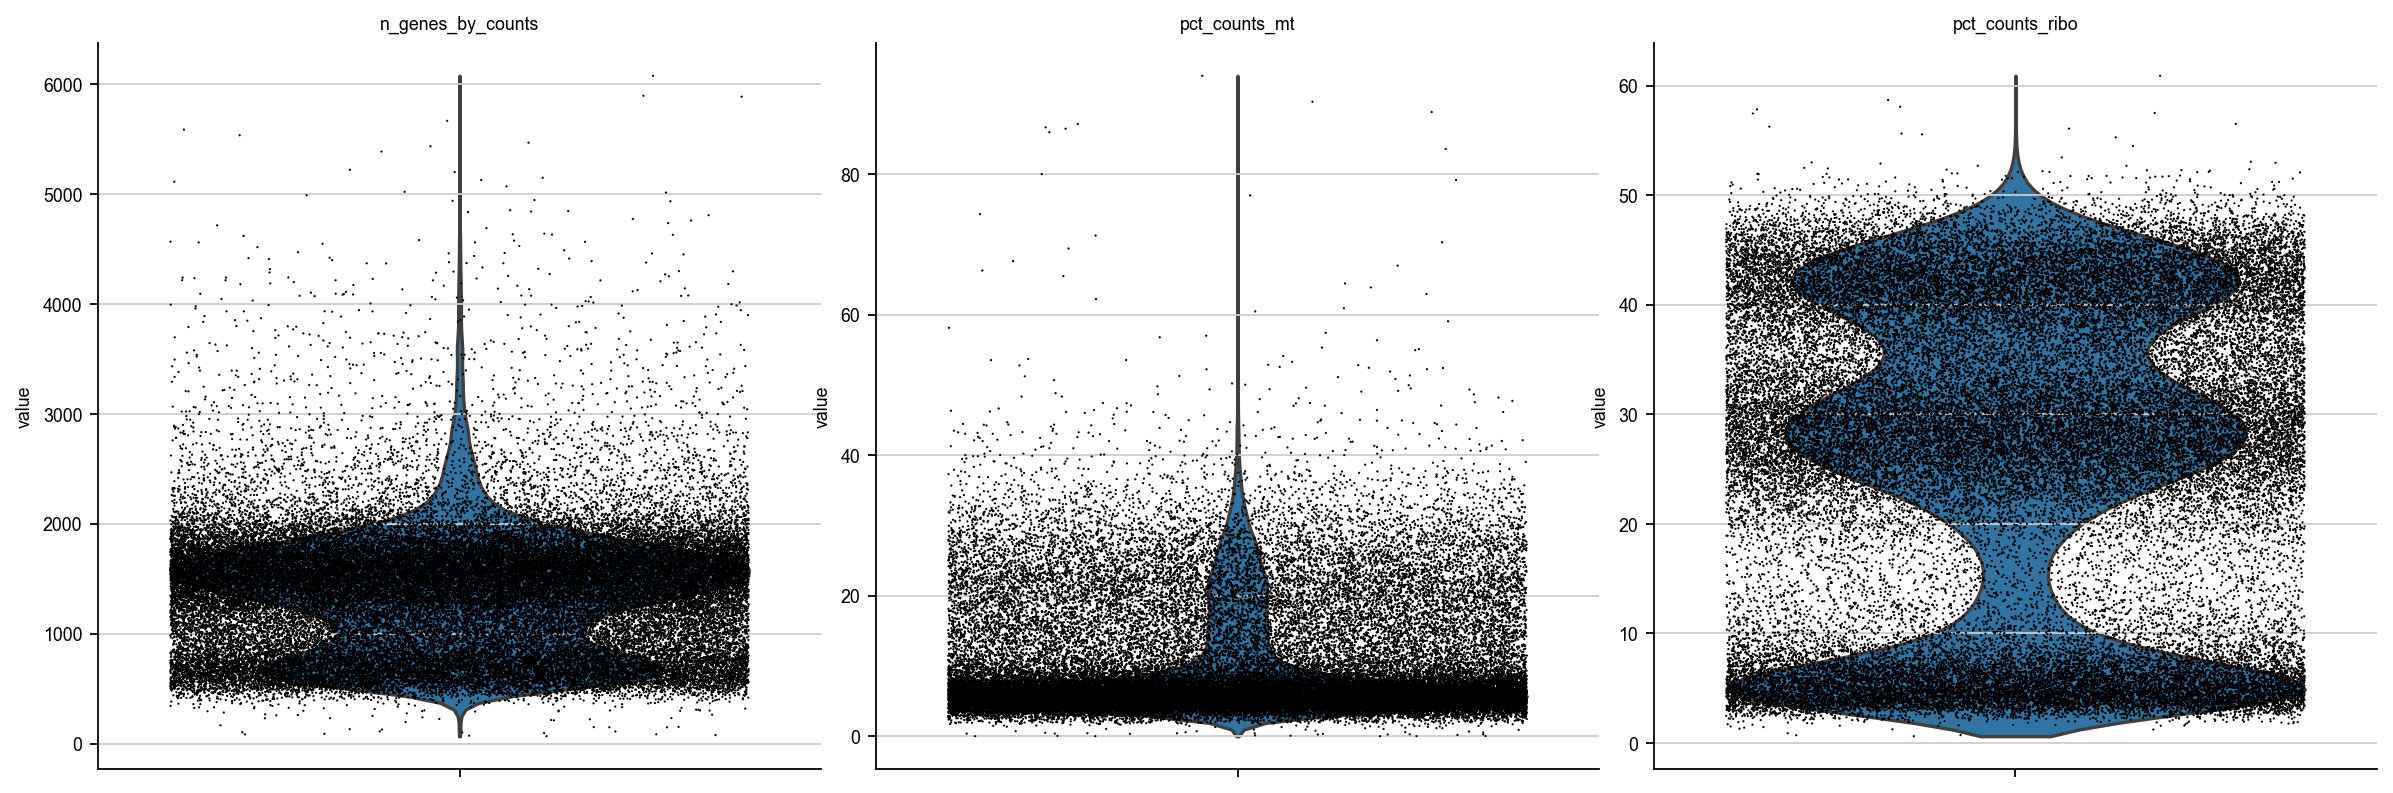

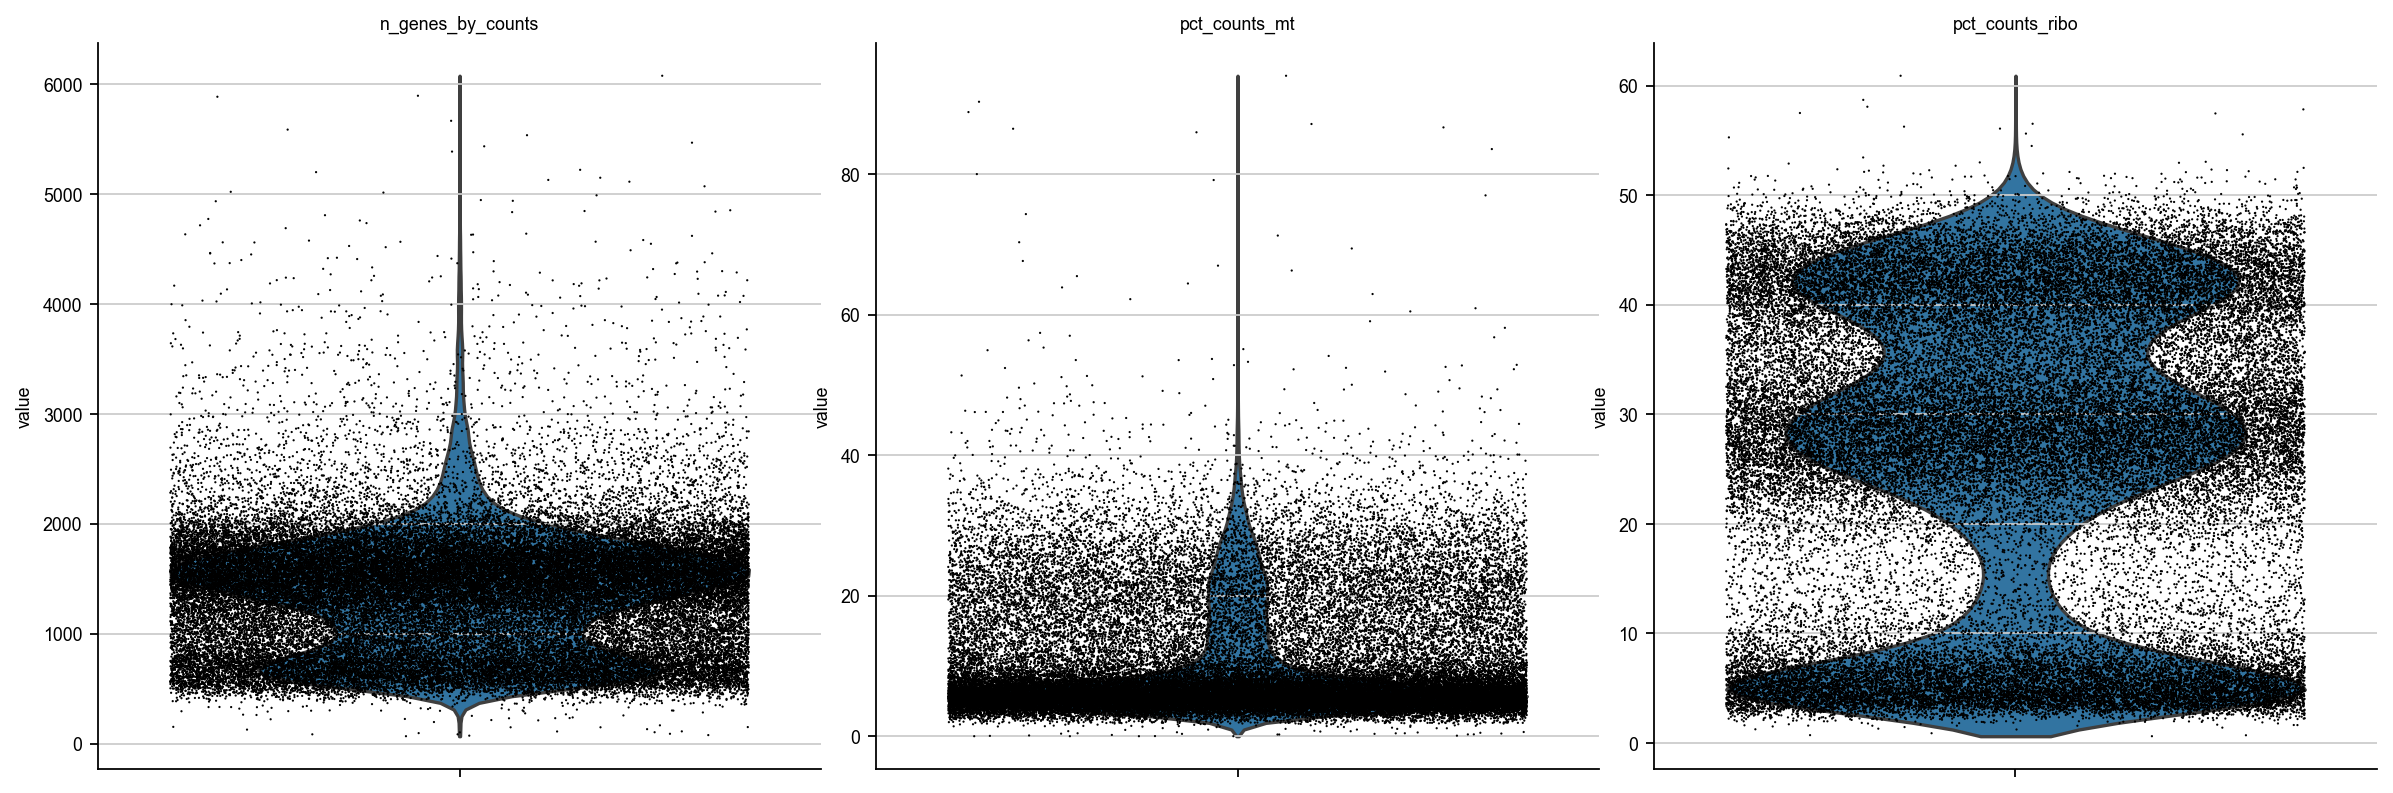

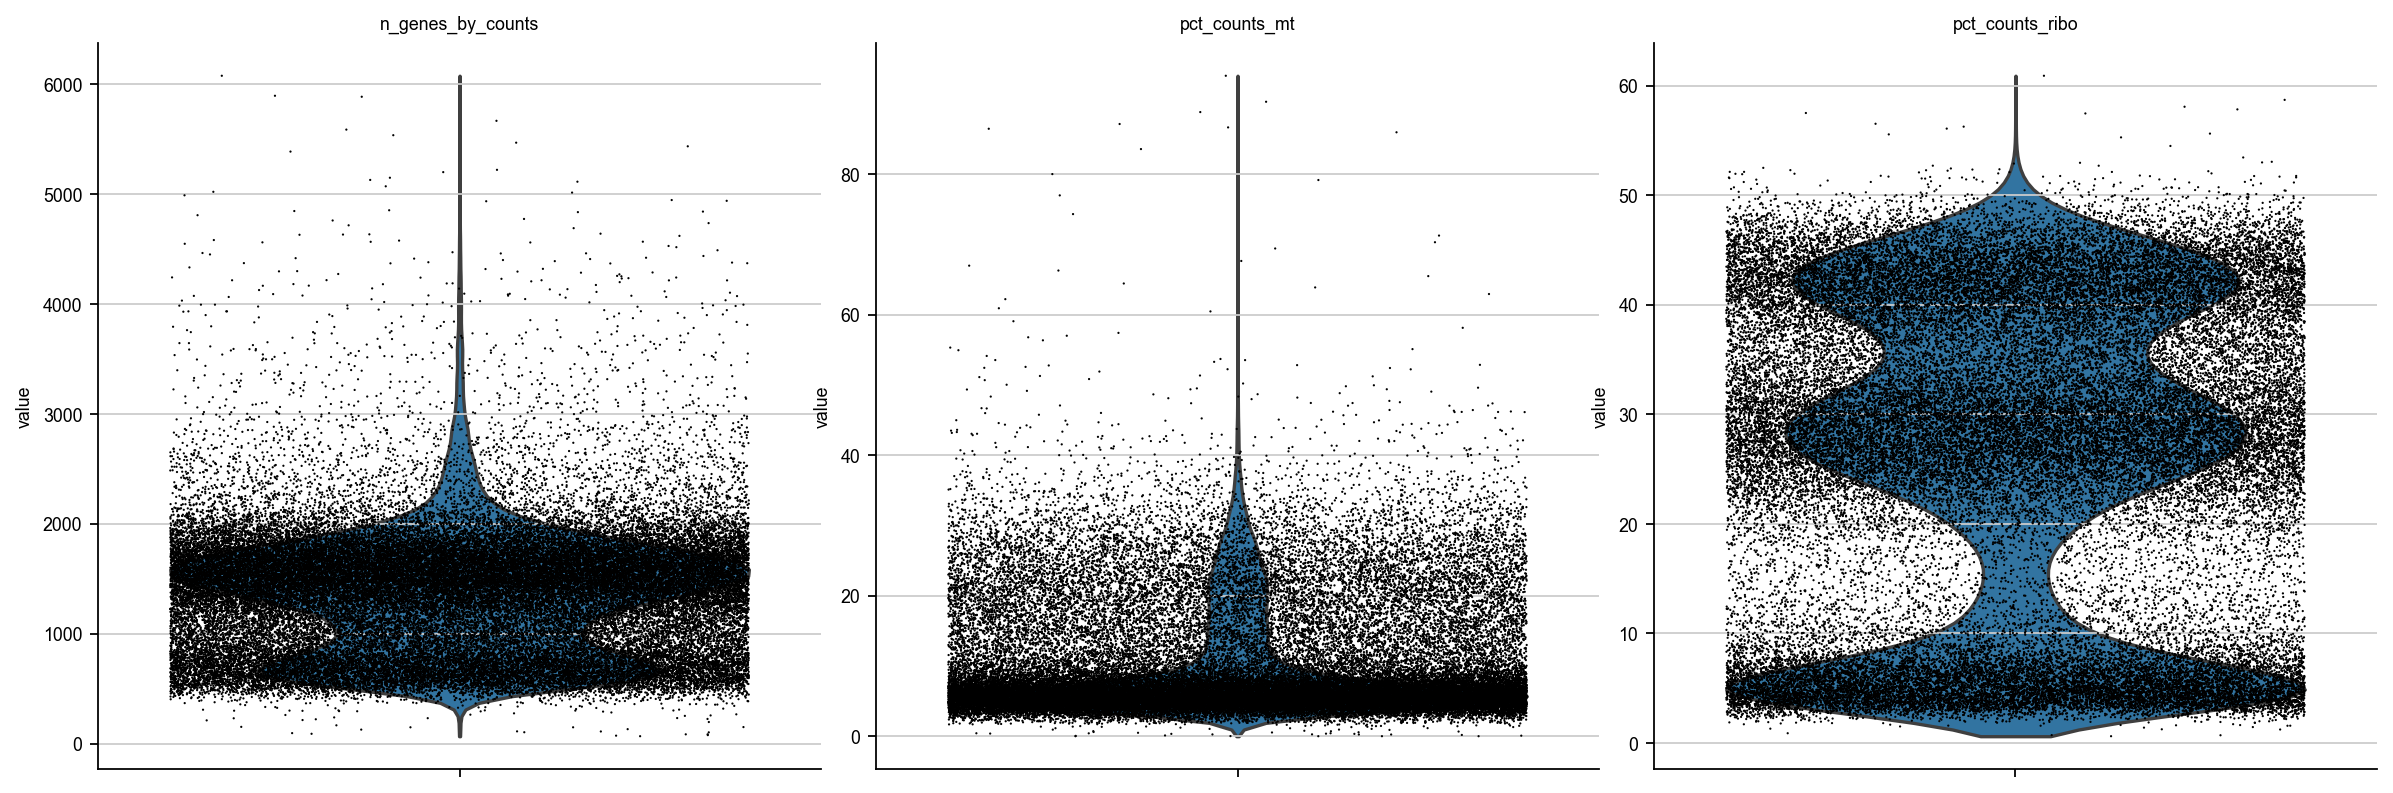

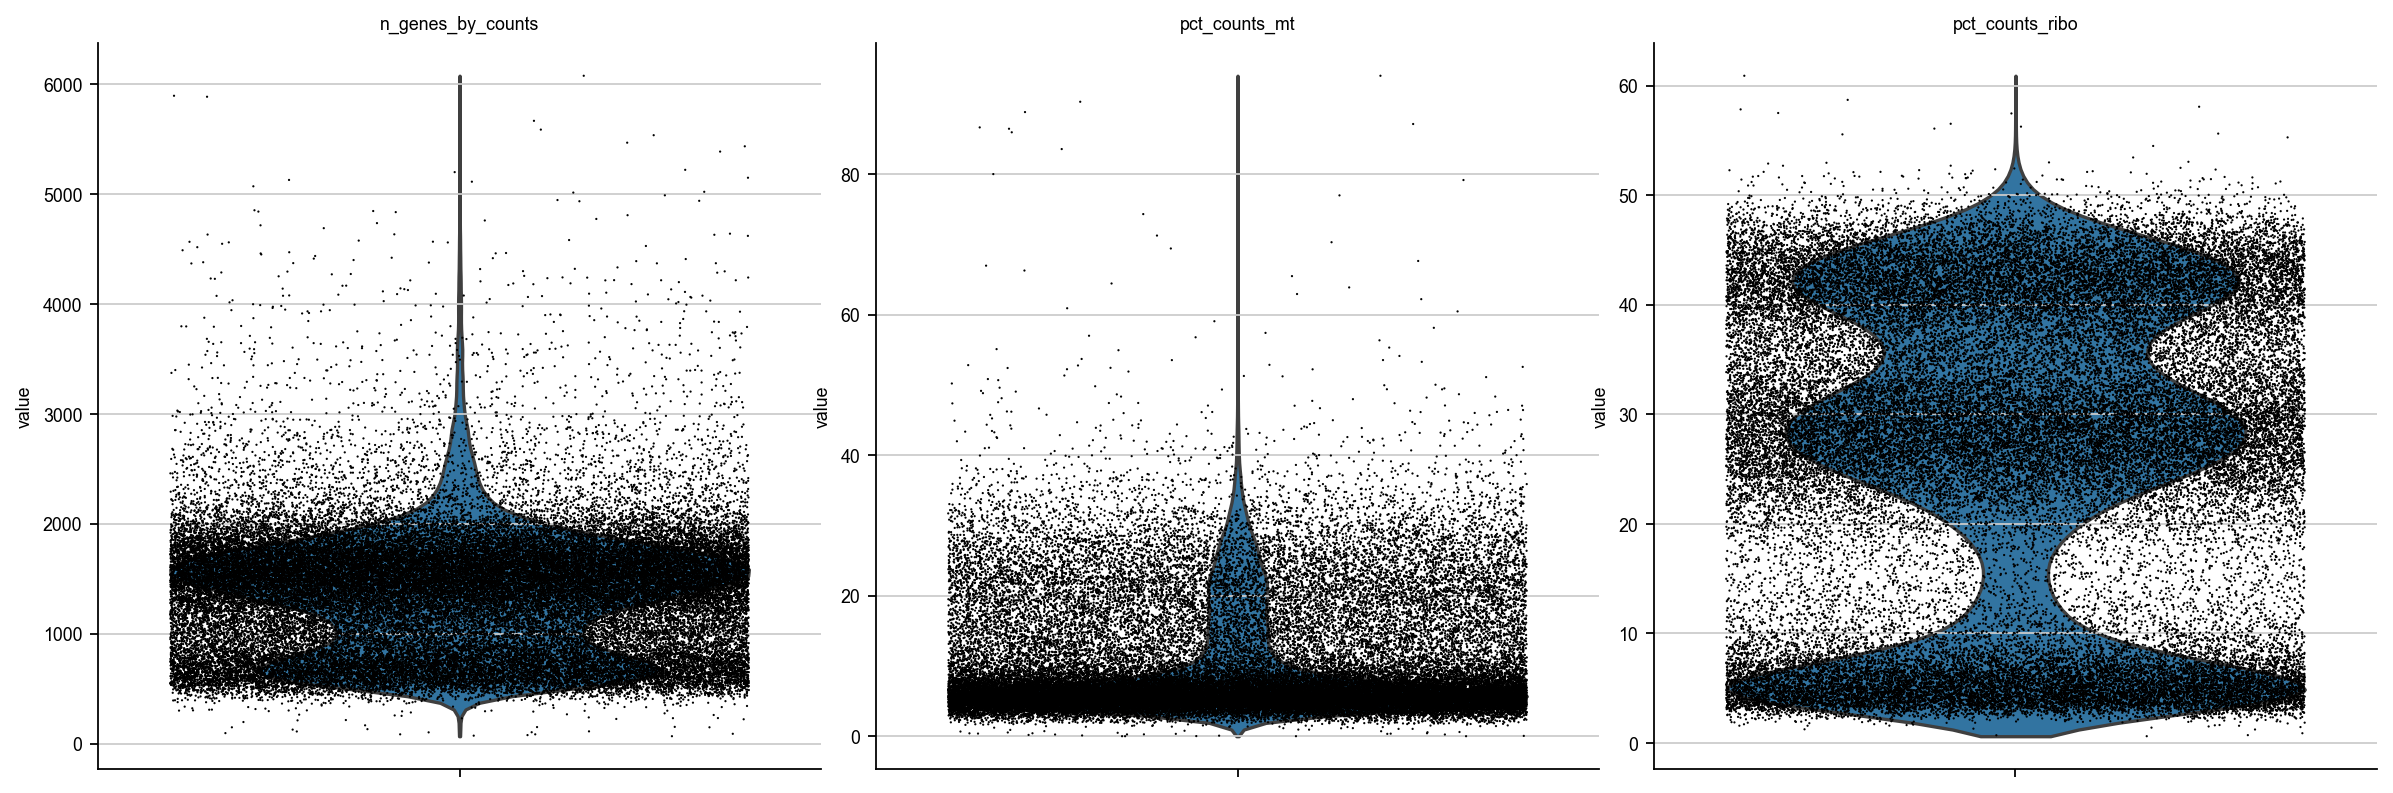

In [200]:
for adata in [adata1,adata2,adata3,adata4]:
    adata=prepare_metrics(adata)
    sc.pl.violin(adata1, ['n_genes_by_counts', 'pct_counts_mt','pct_counts_ribo'],
    jitter=0.4, multi_panel=True)

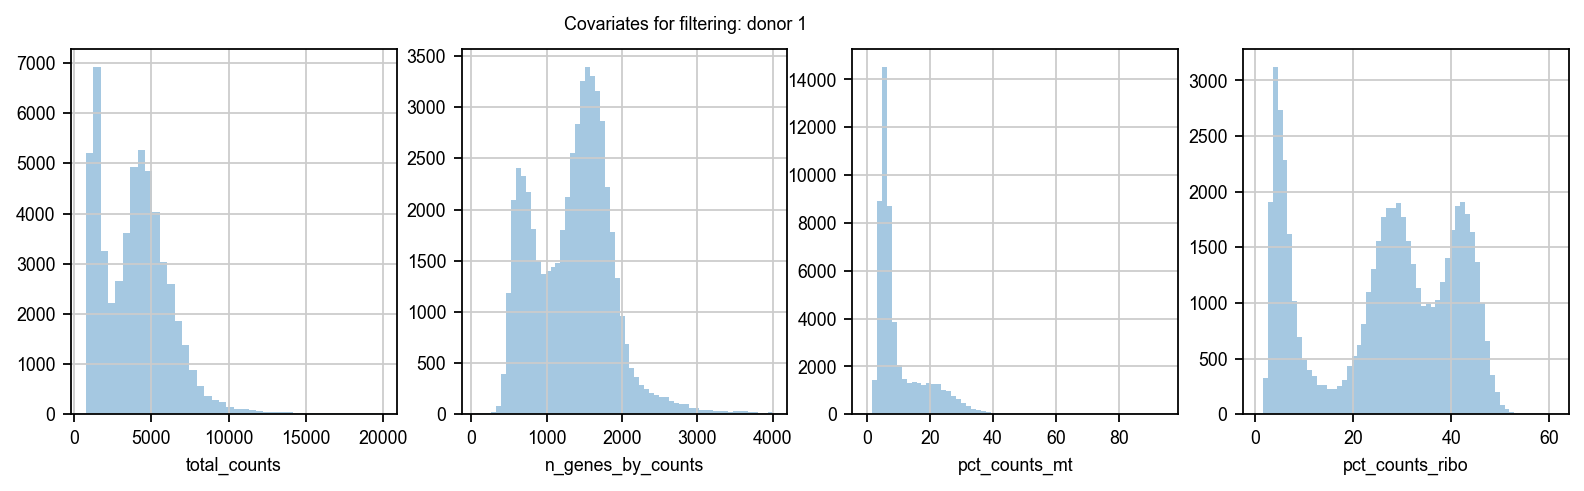

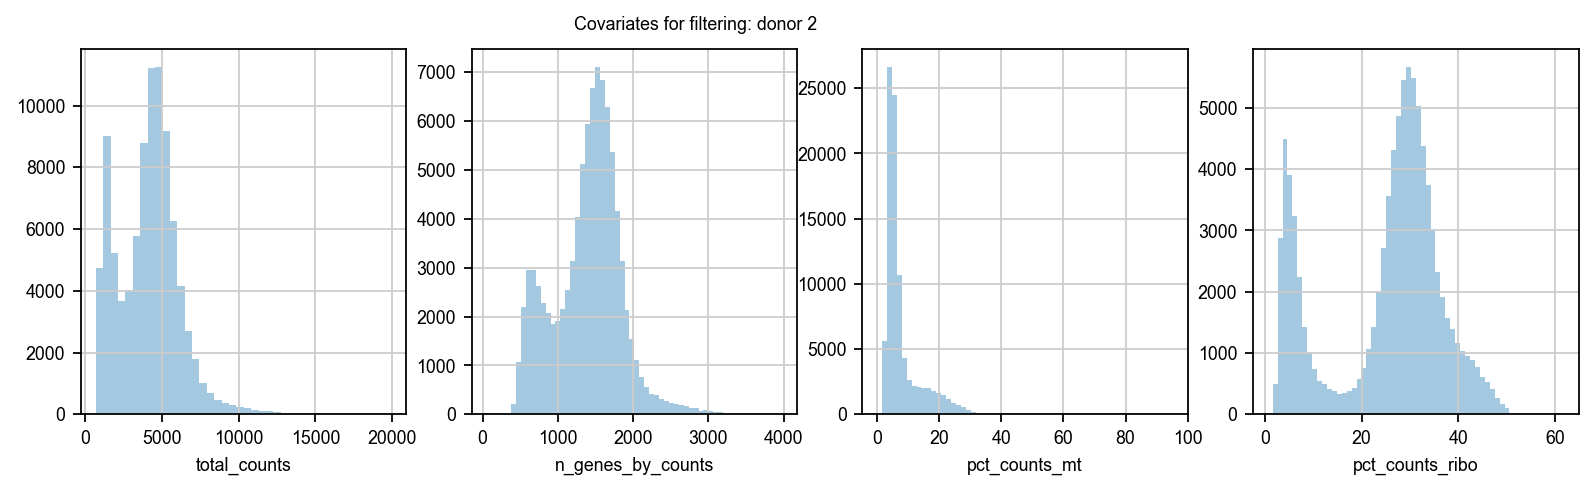

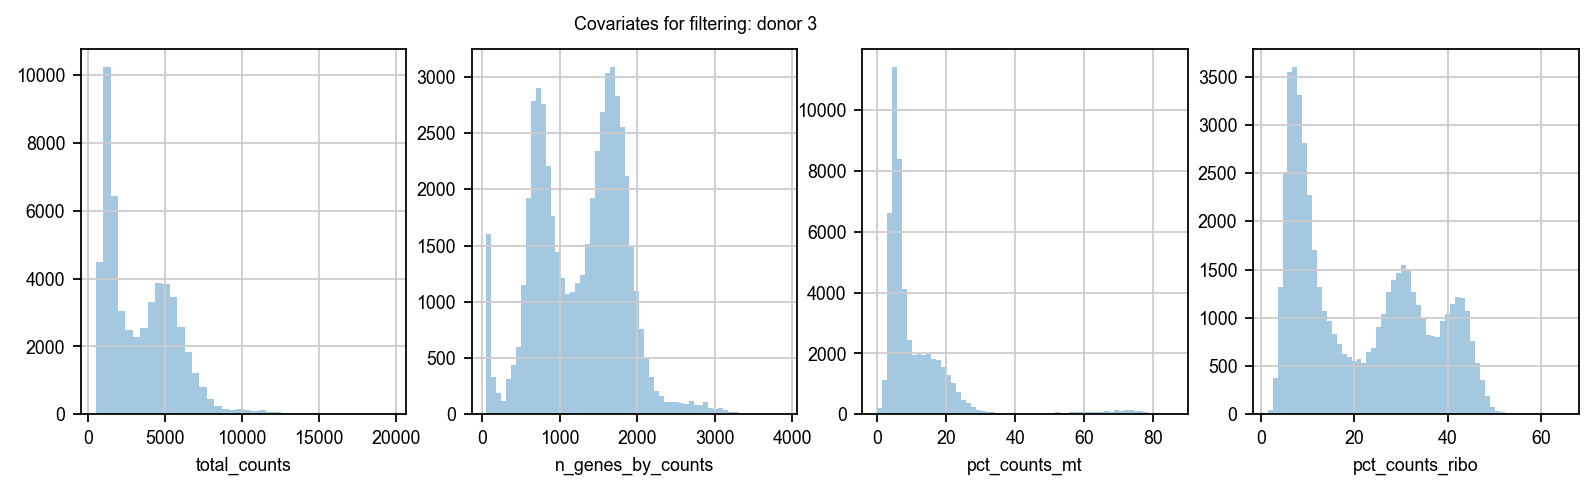

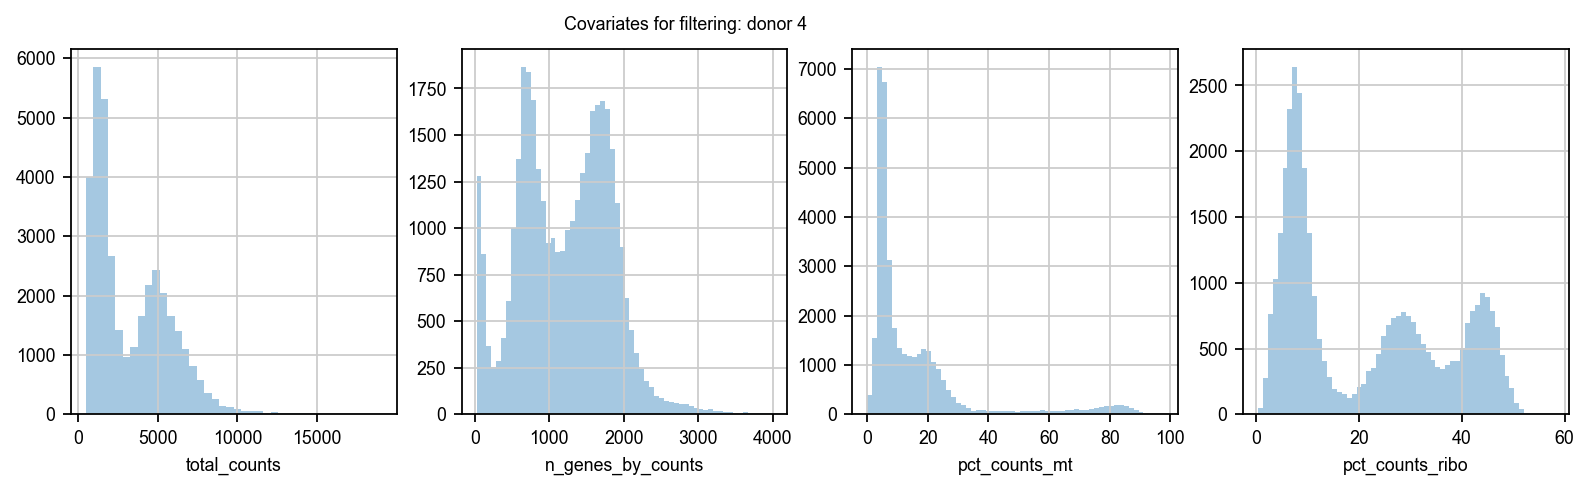

In [204]:
for name, adata in [
    ("donor 1", adata1),
    ("donor 2", adata2),
    ("donor 3", adata3),
    ("donor 4", adata4),
    ]:
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    fig.suptitle(f"Covariates for filtering: {name}")

    sns.distplot(
        adata.obs["total_counts"][adata.obs["total_counts"] < 20000],
        kde=False,
        bins=40,
        ax=axs[0],
    )
    sns.distplot(
        adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
        kde=False,
        bins=60,
        ax=axs[1],
    )
    sns.distplot(
        adata.obs["pct_counts_mt"],
        kde=False,
        bins=60,
        ax=axs[2],
    )
    sns.distplot(
        adata.obs["pct_counts_ribo"],
        kde=False,
        bins=60,
        ax=axs[3],
    )

In [58]:
from scipy.signal import argrelextrema,find_peaks

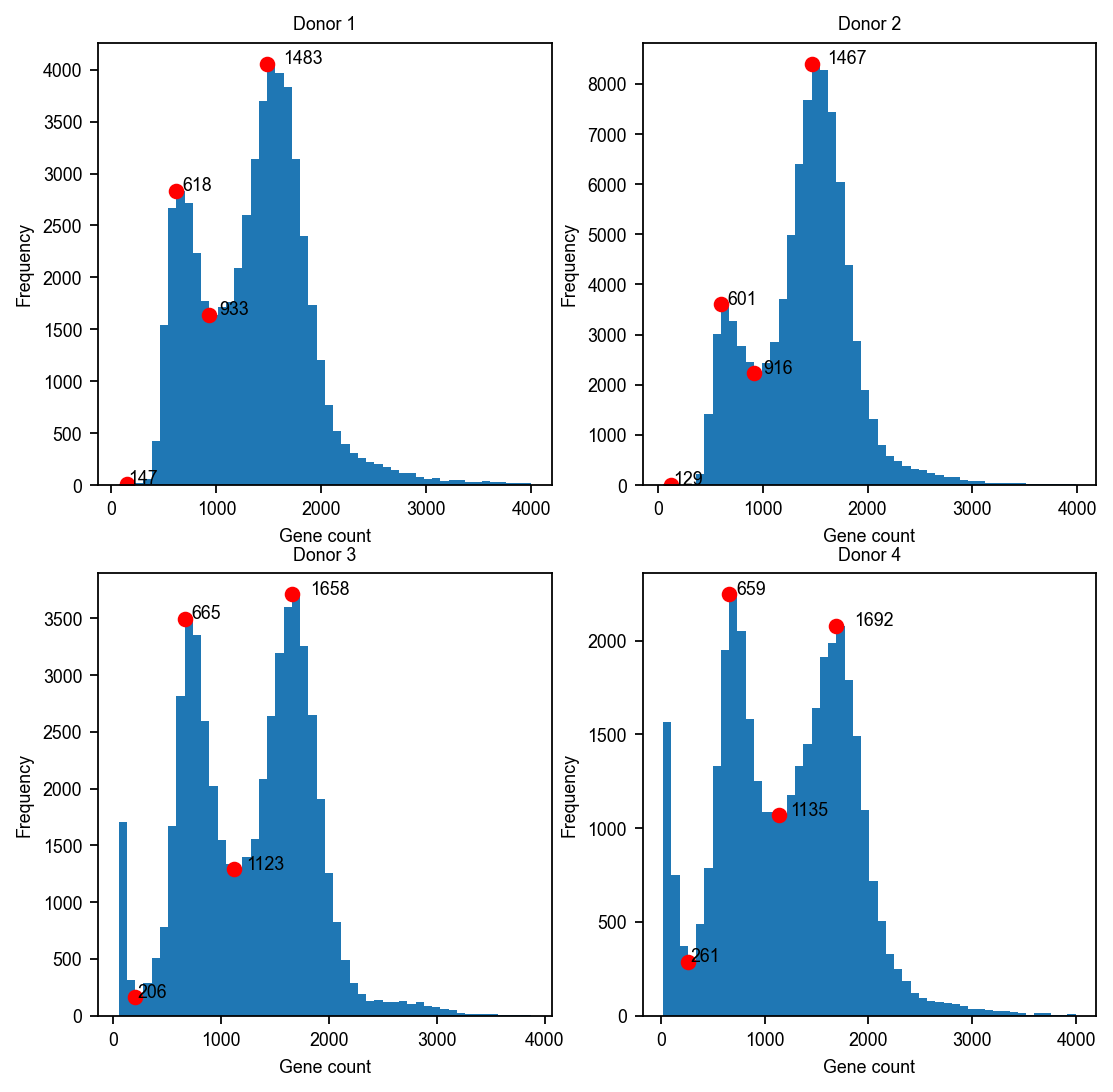

In [154]:
def get_peaks(hist,donor):
    freq=hist[0]
    bin=hist[1]
    peaks=sorted(find_peaks(freq, distance=int(max(freq)/750))[0])[:2]
    Y=[freq[p] for p in peaks]
    X=[bin[p] for p in peaks]
    
    sub=freq[peaks[0]:peaks[1]]
    minY = min(sub)
    minX=bin[list(freq).index(minY)]
    X= X + [minX]
    Y= Y + [minY]
    # if donor=='Donor 3' or donor == 'Donor 4':
    sub2=freq[:peaks[0]]
    # print(sub2)
    minY2 = min(sub2)
    minX2=bin[list(freq).index(minY2)]
    X= X + [minX2]
    Y= Y + [minY2]

  
    coords=[(X[i],Y[i]) for i in range(len(X))]
    # print(coords)
    return X,Y, coords

def plot_genecount(adata_list,names):
    size=8
    plt.rc('font', size=size)          # controls default text sizes
    plt.rc('xtick', labelsize=size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=size)    # fontsize of the tick labels
    plt.rc('figure', titlesize=size)  # fontsize of the figure title
    fig,ax = plt.subplots(2,2,figsize=(8,8))
    i=0
    for x in [0,1]:
        for y in [0,1]:
            adata=adata_list[i]
            arr=adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"]<4000].values
            out=ax[x,y].hist(arr,bins=50)
            X,Y,coords=get_peaks(out,names[i])
            ax[x,y].scatter(X,Y,c='red')
            ax[x,y].set_title(names[i])
            # print(coords)
            for c in coords:
                # print(c)
                ax[x,y].annotate('{:.0f}'.format(c[0]),xy=(1.1*c[0],c[1]),fontsize=8)
            del arr, out, X, Y
            ax[x,y].grid(None)
            ax[x,y].set_ylabel('Frequency')
            ax[x,y].set_xlabel('Gene count')
            i+=1
    plt.show()


    
plot_genecount([adata1,adata2,adata3,adata4],['Donor 1','Donor 2','Donor 3','Donor 4'])



In [210]:
def annotate(hist,cutoff):
    freq=hist[0]
    bin=hist[1]
    dif = [abs(b -cutoff) for b in bin]
    idx = dif.index(min(dif))
    x=bin[idx]
    y=freq[idx]
    return (x,y) 
    # print(dif)
    # Y=[freq[p] for p in peaks]
    # X=[bin[p] for p in peaks]
    
    # sub=freq[peaks[0]:peaks[1]]
    # minY = min(sub)
    # minX=bin[list(freq).index(minY)]
    # X= X + [minX]
    # Y= Y + [minY]
    # # if donor=='Donor 3' or donor == 'Donor 4':
    # sub2=freq[:peaks[0]]
    # # print(sub2)
    # minY2 = min(sub2)
    # minX2=bin[list(freq).index(minY2)]
    # X= X + [minX2]
    # Y= Y + [minY2]

  
    # coords=[(X[i],Y[i]) for i in range(len(X))]
    # # print(coords)
    # return X,Y, coords

def plot_pct(adata_list,names,mito_ribo,cutoff):
    size=8
    plt.rc('font', size=size)          # controls default text sizes
    plt.rc('xtick', labelsize=size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=size)    # fontsize of the tick labels
    plt.rc('figure', titlesize=size)  # fontsize of the figure title
    fig,ax = plt.subplots(2,2,figsize=(8,8))
    i=0
    for x in [0,1]:
        for y in [0,1]:
            adata=adata_list[i]
            arr=adata.obs["pct_counts_%s"%(mito_ribo)].values
            out=ax[x,y].hist(arr,bins=50)
            coords=annotate(out,cutoff)
            ax[x,y].scatter(coords[0],coords[1],c='red')
            ax[x,y].set_title(names[i])
            ax[x,y].annotate('{:.0f}%'.format(cutoff),xy=(1.1*coords[0],coords[1]),fontsize=8)
            ax[x,y].grid(None)
            ax[x,y].set_ylabel('Frequency')
            if mito_ribo=='mt':
                ax[x,y].set_xlabel('% Mitochondrial genes')
            elif mito_ribo=='ribo':
                ax[x,y].set_xlabel('% Ribosomal genes')
            else:
                raise KeyError('Select inout from "mt', "ribo")
            i+=1
    plt.show()

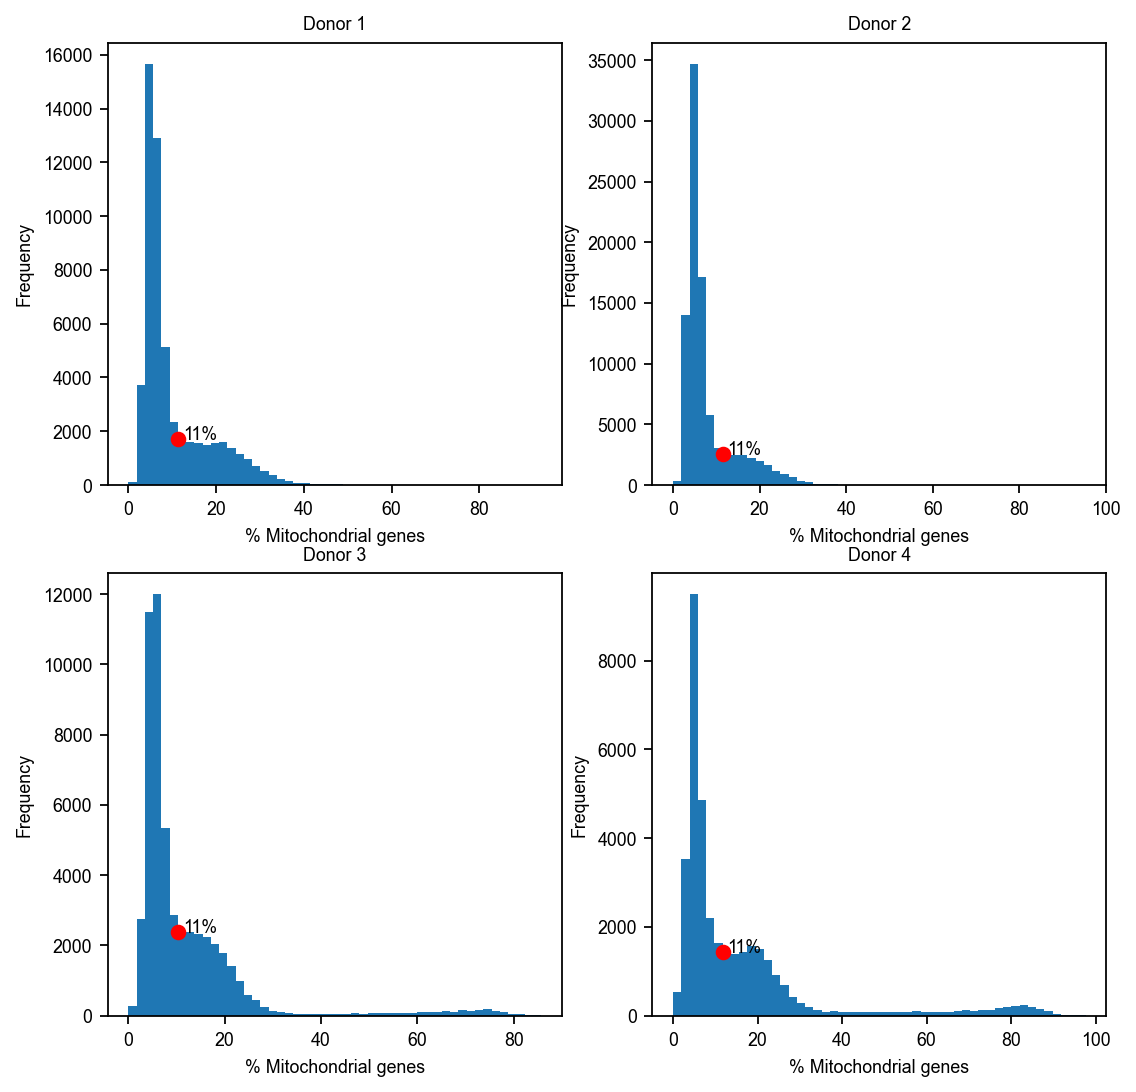

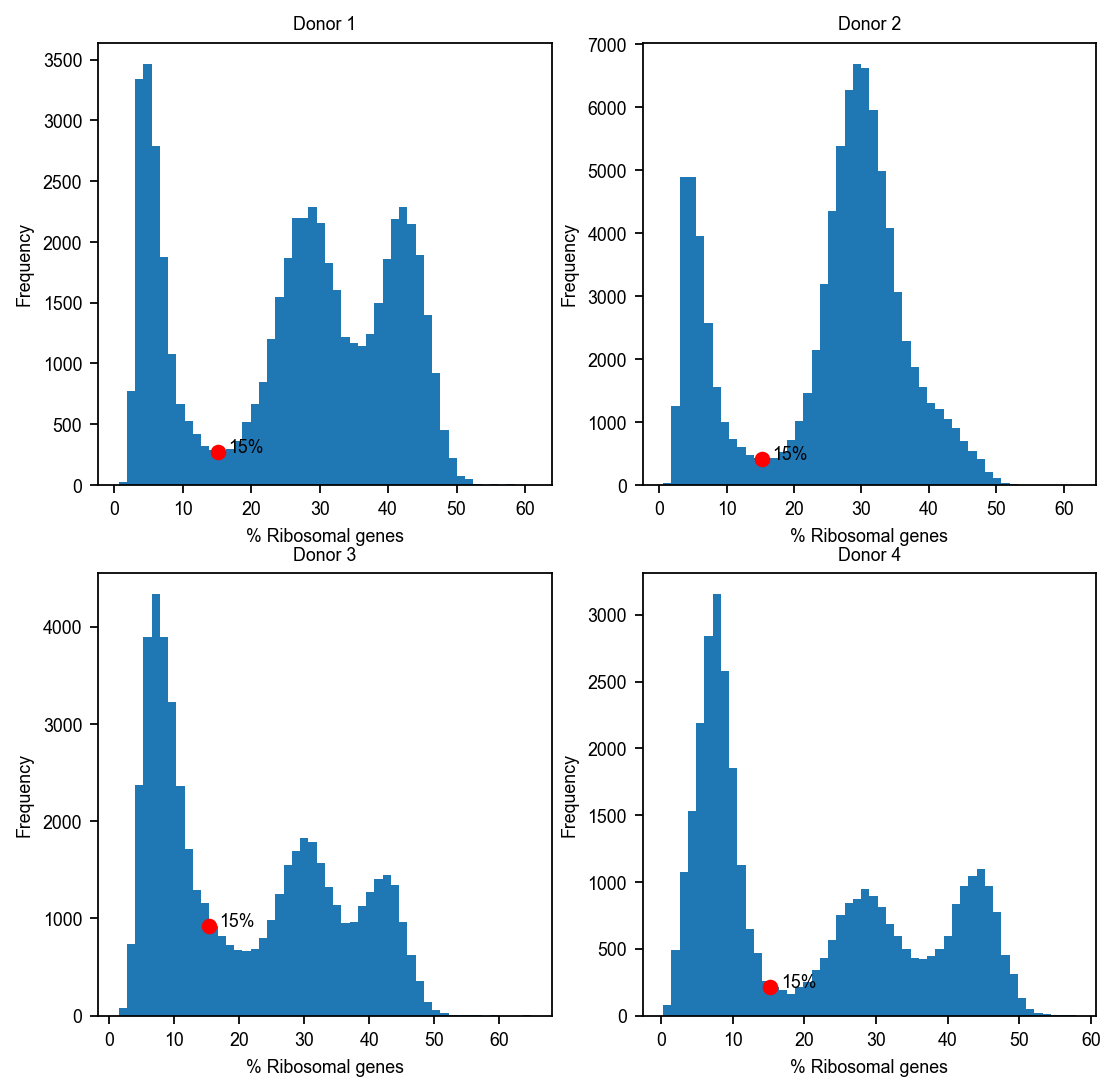

In [225]:
adata_list=[adata1,adata2,adata3,adata4]
names=['Donor 1','Donor 2','Donor 3','Donor 4']
plot_pct(adata_list,names,'mt',11)
plot_pct(adata_list,names,'ribo',15)

In [317]:
# for adata in adata_list:
#     ir.tl.chain_qc(adata)
def inspect_chains(adata_list,names,preprocess):

    out=pd.DataFrame()
    r=0
    
    for i,adata in enumerate(adata_list):
        if preprocess:
            # Drop multichain instances
            adata = adata[adata.obs["chain_pairing"] != "multichain", :].copy()

            # Drop single chain instances and unproductive sequences
            adata = adata[~adata.obs["chain_pairing"].isin(["orphan VDJ", "orphan VJ","no IR"]), :].copy()
        
        X = list(set(adata.obs['chain_pairing'].values))
        x_pos=np.arange(len(X))*1.2
        df=adata.obs
        d=[names[i]]*len(df)
        df.index=d
        
        Y=[len(df[df['chain_pairing']==x]) for x in X]
        plt.bar(x_pos+r,Y,width=0.2,label=names[i])
        plt.xticks([n +0.6 for n in x_pos],X,rotation=90)
        plt.ylabel('Frequency')
        plt.grid(False)
        r+=0.3
        plt.legend()
    plt.show()


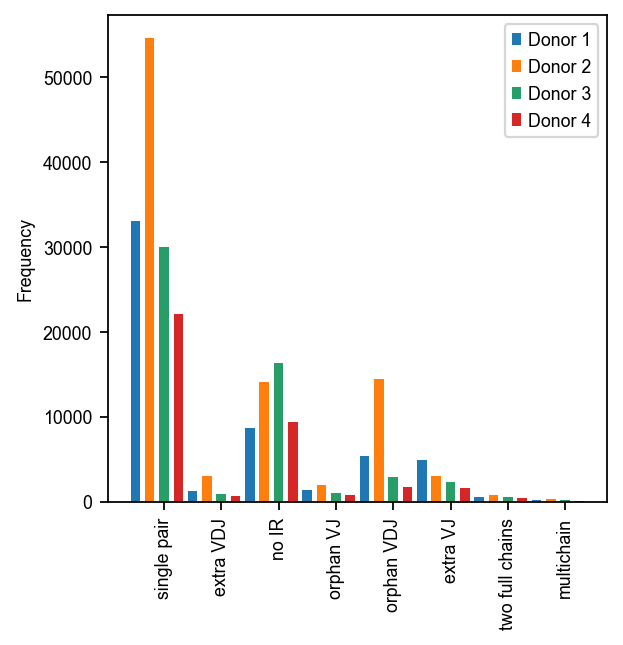

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


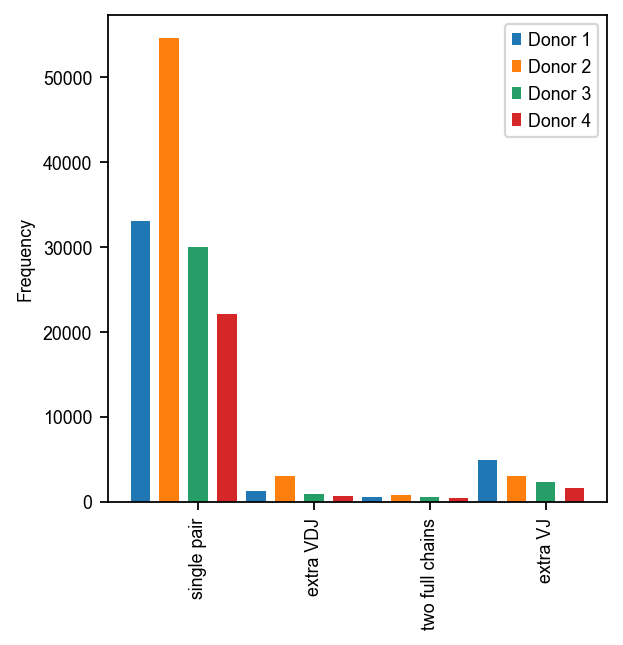

In [318]:
inspect_chains(adata_list,names,preprocess=False)
inspect_chains(adata_list,names,preprocess=True)